# Auto lithofacies classification (unsupervised cluster analysis)

This notebook demonstrates how to read four CSV files (CT, RGB, MST, hi-res MS) for core M9907-22PC, merge them using a shared depth column, perform unsupervised K-Means clustering on selected log columns, and visualize the clustered intervals versus depth.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import random
import matplotlib.collections as mcoll
from scipy import stats
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
# Resample each dataset to the common depth scale
from scipy.interpolate import interp1d

from scipy.signal import savgol_filter

# from pyCoreRelator import plot_core_data

# Setup: directories, config, file paths, columns

In [2]:
# Core parameters
core_name = "M9907-23PC"  # Core name
total_length_cm = 783     # Core length in cm

# Configuration dictionaries
data_config = {
    'mother_dir': '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/',
    'core_name': core_name,
    'core_length': total_length_cm,
    'data_folder': f'_compiled_logs/{core_name}/',
    'clean_output_folder': f'_compiled_logs/{core_name}/ML_clean/',
    'filled_output_folder': f'_compiled_logs/{core_name}/ML_filled/',
    'thresholds': {
        'ms': ['>', 150, 1],
        'pwvel': ['>', 1085, 3],
        'den': ['<', 1, 1],
        'elecres': ['<', 0, 1],
        'hiresms': ['<=', 24, 1]
    }
}

mother_dir = data_config['mother_dir']
core_length = data_config['core_length']
clean_output_folder = data_config['clean_output_folder']
filled_output_folder = data_config['filled_output_folder']

# Load CT and RGB images
ct_img_path = mother_dir + f'_compiled_logs/{core_name}/{core_name}_CT.tiff'
rgb_img_path = mother_dir + f'_compiled_logs/{core_name}/{core_name}_RGB.tiff'

ct_img = plt.imread(ct_img_path)
rgb_img = plt.imread(rgb_img_path)

# Configuration for log data column auto-selection within the functions
column_configs = {
    'ct': {
        'data_col': 'CT',
        'std_col': 'CT_std',
        'depth_col': 'SB_DEPTH_cm'
    },
    'rgb': {
        'data_cols': ['R', 'G', 'B', 'Lumin'],
        'std_cols': ['R_std', 'G_std', 'B_std', 'Lumin_std'],
        'depth_col': 'SB_DEPTH_cm'
    },
    'mst': {
        'density':  {'data_col': 'Den_gm/cc',    'depth_col': 'SB_DEPTH_cm'},
        'pwvel':    {'data_col': 'PWVel_m/s',    'depth_col': 'SB_DEPTH_cm'},
        'pwamp':    {'data_col': 'PWAmp',        'depth_col': 'SB_DEPTH_cm'},
        # 'elecres':  {'data_col': 'ElecRes_ohmm', 'depth_col': 'SB_DEPTH_cm'},
        'ms':       {'data_col': 'MS',           'depth_col': 'SB_DEPTH_cm'},
    },
    'hrms': {
        'data_col': 'hiresMS',
        'depth_col': 'SB_DEPTH_cm'
    }
}

# Paths to each CSV
clean_data_paths = {
    'ct': mother_dir + clean_output_folder + f'{core_name}_CT_clean.csv',
    'rgb': mother_dir + clean_output_folder + f'{core_name}_RGB_clean.csv', 
    'mst': mother_dir + clean_output_folder + f'{core_name}_MST_clean.csv',
    'hrms': mother_dir + clean_output_folder + f'{core_name}_hiresMS_clean.csv'
}

filled_data_paths = {
    'ct':  os.path.join(mother_dir, filled_output_folder, f'{core_name}_CT_MLfilled.csv'),
    'rgb': os.path.join(mother_dir, filled_output_folder, f'{core_name}_RGB_MLfilled.csv'),
    'mst': os.path.join(mother_dir, filled_output_folder, f'{core_name}_MST_MLfilled.csv'),
    'hrms':os.path.join(mother_dir, filled_output_folder, f'{core_name}_hiresMS_MLfilled.csv')
}

df_ct = pd.read_csv(filled_data_paths['ct'])
df_rgb = pd.read_csv(filled_data_paths['rgb'])
df_mst = pd.read_csv(filled_data_paths['mst'])
df_hrms = pd.read_csv(filled_data_paths['hrms'])

print("Shapes of loaded DataFrames:")
print("df_ct:", df_ct.shape)
print("df_rgb:", df_rgb.shape)
print("df_mst:", df_mst.shape)
print("df_hrms:", df_hrms.shape)

Shapes of loaded DataFrames:
df_ct: (1567, 4)
df_rgb: (1567, 10)
df_mst: (1566, 10)
df_hrms: (1566, 2)


# Extract and Rename Columns
Use the `column_configs` dictionary to subset and rename columns for each dataset, ensuring a consistent `'depth'` column.

In [ ]:
# CT subset
ct_depth_col = column_configs['ct']['depth_col']
ct_data_col = column_configs['ct']['data_col']
ct_std_col = column_configs['ct']['std_col']
df_ct_subset = df_ct[[ct_depth_col, ct_data_col, ct_std_col]].copy()
df_ct_subset.rename(columns={
    ct_depth_col: 'depth',
    ct_data_col: 'CT',
    ct_std_col: 'CT_std'
}, inplace=True)

# RGB subset
rgb_depth_col = column_configs['rgb']['depth_col']
rgb_data_cols = column_configs['rgb']['data_cols']  # ['R','G','B','Lumin']
rgb_std_cols = column_configs['rgb']['std_cols']   # ['R_std','G_std','B_std','Lumin_std']
df_rgb_subset = df_rgb[[rgb_depth_col] + rgb_data_cols + rgb_std_cols].copy()
df_rgb_subset.rename(columns={
    rgb_depth_col: 'depth',
    'R': 'R', 'G': 'G', 'B': 'B', 'Lumin': 'Lumin',
    'R_std': 'R_std', 'G_std': 'G_std', 'B_std': 'B_std', 'Lumin_std': 'Lumin_std'
}, inplace=True)

# MST subset
mst_config = column_configs['mst']
mst_depth_col = mst_config['density']['depth_col']
mst_cols = [
    mst_config['density']['data_col'],
    mst_config['pwvel']['data_col'],
    mst_config['pwamp']['data_col'],
    # mst_config['elecres']['data_col'],
    mst_config['ms']['data_col']
]
df_mst_subset = df_mst[[mst_depth_col] + mst_cols].copy()
df_mst_subset.rename(columns={
    mst_depth_col: 'depth',
    mst_config['density']['data_col']:  'Density',
    mst_config['pwvel']['data_col']:    'PWVel',
    mst_config['pwamp']['data_col']:    'PWAmp',
    # mst_config['elecres']['data_col']:  'ElecRes',
    mst_config['ms']['data_col']:       'MS'
}, inplace=True)

# hi-res MS subset
hrms_depth_col = column_configs['hrms']['depth_col']
hrms_data_col  = column_configs['hrms']['data_col']
df_hrms_subset = df_hrms[[hrms_depth_col, hrms_data_col]].copy()
df_hrms_subset.rename(columns={
    hrms_depth_col: 'depth',
    hrms_data_col:  'hiresMS'
}, inplace=True)

# # Create a common depth scale based on hrms (high-resolution magnetic susceptibility)
# Generate a depth scale with 2 times higher resolution than hiresMS
min_depth = df_hrms_subset['depth'].min()
max_depth = df_hrms_subset['depth'].max()
# Calculate the average step size in the original hiresMS data
avg_step = np.mean(np.diff(np.sort(df_hrms_subset['depth'].unique())))
# Create new depth scale with the same resolution as hiresMS
common_depths = np.arange(min_depth, max_depth + avg_step/4, avg_step/2)   #resample to 2x of the hiresMS depth resolution


# CT data resampling
ct_interp = interp1d(df_ct_subset['depth'], df_ct_subset['CT'], 
                    bounds_error=False, fill_value=np.nan)
ct_std_interp = interp1d(df_ct_subset['depth'], df_ct_subset['CT_std'], 
                        bounds_error=False, fill_value=np.nan)

# RGB data resampling
r_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['R'], 
                   bounds_error=False, fill_value=np.nan)
g_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['G'], 
                   bounds_error=False, fill_value=np.nan)
b_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['B'], 
                   bounds_error=False, fill_value=np.nan)
lumin_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['Lumin'], 
                       bounds_error=False, fill_value=np.nan)
r_std_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['R_std'], 
                       bounds_error=False, fill_value=np.nan)
g_std_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['G_std'], 
                       bounds_error=False, fill_value=np.nan)
b_std_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['B_std'], 
                       bounds_error=False, fill_value=np.nan)
lumin_std_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['Lumin_std'], 
                           bounds_error=False, fill_value=np.nan)

# MST data resampling
density_interp = interp1d(df_mst_subset['depth'], df_mst_subset['Density'], 
                         bounds_error=False, fill_value=np.nan)
pwvel_interp = interp1d(df_mst_subset['depth'], df_mst_subset['PWVel'], 
                       bounds_error=False, fill_value=np.nan)
pwamp_interp = interp1d(df_mst_subset['depth'], df_mst_subset['PWAmp'], 
                       bounds_error=False, fill_value=np.nan)
ms_interp = interp1d(df_mst_subset['depth'], df_mst_subset['MS'], 
                    bounds_error=False, fill_value=np.nan)

# Get interpolated values
ct_values = ct_interp(common_depths)
ct_std_values = ct_std_interp(common_depths)
r_values = r_interp(common_depths)
g_values = g_interp(common_depths)
b_values = b_interp(common_depths)
lumin_values = lumin_interp(common_depths)
r_std_values = r_std_interp(common_depths)
g_std_values = g_std_interp(common_depths)
b_std_values = b_std_interp(common_depths)
lumin_std_values = lumin_std_interp(common_depths)
density_values = density_interp(common_depths)
pwvel_values = pwvel_interp(common_depths)
pwamp_values = pwamp_interp(common_depths)
ms_values = ms_interp(common_depths)

# Apply smoothing using a Savitzky-Golay filter
window_length = 5  # Must be odd number
polyorder = 3  # Polynomial order for fitting
edge_points = window_length // 2  # Number of points to keep unsmoothed at each edge

# Helper function to apply smoothing while preserving edges
def smooth_with_edges(data, window_length, polyorder):
    smoothed = savgol_filter(data, window_length, polyorder)
    # Keep original values at edges
    smoothed[:edge_points] = data[:edge_points]
    smoothed[-edge_points:] = data[-edge_points:]
    return smoothed

# Apply smoothing to all values
ct_values = smooth_with_edges(ct_values, window_length, polyorder)
ct_std_values = smooth_with_edges(ct_std_values, window_length, polyorder)
r_values = smooth_with_edges(r_values, window_length, polyorder)
g_values = smooth_with_edges(g_values, window_length, polyorder)
b_values = smooth_with_edges(b_values, window_length, polyorder)
lumin_values = smooth_with_edges(lumin_values, window_length, polyorder)
r_std_values = smooth_with_edges(r_std_values, window_length, polyorder)
g_std_values = smooth_with_edges(g_std_values, window_length, polyorder)
b_std_values = smooth_with_edges(b_std_values, window_length, polyorder)
lumin_std_values = smooth_with_edges(lumin_std_values, window_length, polyorder)
density_values = smooth_with_edges(density_values, window_length, polyorder)
pwvel_values = smooth_with_edges(pwvel_values, window_length, polyorder)
pwamp_values = smooth_with_edges(pwamp_values, window_length, polyorder)
ms_values = smooth_with_edges(ms_values, window_length, polyorder)

# Create resampled dataframes with smoothed data
df_ct_resampled = pd.DataFrame({
    'depth': common_depths,
    'CT': ct_values,
    'CT_std': ct_std_values
})

df_rgb_resampled = pd.DataFrame({
    'depth': common_depths,
    'R': r_values,
    'G': g_values,
    'B': b_values,
    'Lumin': lumin_values,
    'R_std': r_std_values,
    'G_std': g_std_values,
    'B_std': b_std_values,
    'Lumin_std': lumin_std_values
})

df_mst_resampled = pd.DataFrame({
    'depth': common_depths,
    'Density': density_values,
    'PWVel': pwvel_values,
    'PWAmp': pwamp_values,
    'MS': ms_values
})

# Also resample hiresMS to the new higher resolution depth scale
hiresms_interp = interp1d(df_hrms_subset['depth'], df_hrms_subset['hiresMS'],
                         bounds_error=False, fill_value=np.nan)
df_hrms_subset = pd.DataFrame({
    'depth': common_depths,
    'hiresMS': hiresms_interp(common_depths)
})


# Merge Data
Join the four subset DataFrames on the `'depth'` column (using outer merges) and sort by depth.

In [4]:
# Merge the resampled dataframes
df_merged = df_ct_resampled.merge(df_rgb_resampled, on='depth', how='outer', suffixes=(None, '_rgb'))
df_merged = df_merged.merge(df_mst_resampled, on='depth', how='outer', suffixes=(None, '_mst'))
df_merged = df_merged.merge(df_hrms_subset, on='depth', how='outer')

df_merged.sort_values(by='depth', inplace=True)
df_merged.reset_index(drop=True, inplace=True)

print("Merged Data shape:", df_merged.shape)
df_merged.head(20)

Merged Data shape: (3131, 16)


,depth,CT,CT_std,R,G,B,Lumin,R_std,G_std,B_std,Lumin_std,Density,PWVel,PWAmp,MS,hiresMS
0,0.997452,506.998720,NaN,NaN,NaN,NaN,107.206216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.865196
1,1.247452,510.269127,41.251038,114.940669,109.591411,85.387526,108.981147,6.823258,6.748138,6.518417,6.658147,1.213804,1072.153582,12.256682,23.510785,53.679740
2,1.497452,513.228594,NaN,NaN,NaN,NaN,113.183677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.494285
3,1.747452,513.805037,47.642632,120.176513,115.166010,91.031575,114.488737,5.177959,4.920347,5.044201,4.880636,1.197279,1071.964082,8.482971,21.777069,63.046763
4,1.997452,514.062332,43.916511,119.120959,114.084475,89.297498,113.365610,5.529524,5.265609,5.163458,5.218788,1.177992,1071.986242,7.568718,20.721928,67.599242
5,2.247452,516.589070,40.387726,118.560236,113.515901,88.045970,112.749394,6.321573,5.974158,5.629566,5.933755,1.169988,1071.985433,8.228621,20.800919,66.820263
6,2.497452,518.275996,37.334135,118.492172,113.573442,87.843837,112.761484,7.197851,6.795906,6.379313,6.763448,1.168440,1071.976427,10.001132,20.510258,66.041283
7,2.747452,517.316911,35.433131,118.519477,113.931555,88.664315,113.082653,7.791964,7.504312,7.293194,7.460492,1.164781,1071.941489,11.626217,18.470859,55.522658
8,2.997452,513.164750,34.588552,117.828565,113.554255,88.907332,112.683468,7.812563,7.659273,7.759639,7.602428,1.163374,1071.996672,12.738197,16.553235,45.004031
9,3.247452,507.207095,33.949874,115.798186,111.534590,86.832078,110.657513,7.322046,7.114707,7.347038,7.068181,1.165169,1072.204335,13.125633,16.394001,40.165510


<hr>

# Trying Different Numbers of Clusters

You can loop over several k values (say, 2 to 8), compute the inertia (within-cluster sum of squares) or silhouette score, and then compare. Here’s an example of the elbow method.

	•	Inertia often decreases quickly at first, then levels off. That “elbow” can guide your choice of k.
	•	The silhouette score ranges between -1 (poor) and 1 (great). A higher value usually indicates more distinct clusters.

Once you pick a k, you can run the final K-Means again (like you already do).

In [5]:
# Columns to cluster on
feature_cols = [
    'CT', 
    # 'CT_std',
    # 'R', 'G', 'B', 'Lumin',
    'Lumin',
    # 'R_std', 'G_std', 'B_std', 'Lumin_std',
    'Density',
    #'MS',
    # 'ElecRes', 
    'hiresMS',
    # Include PWVel and PWAmp but with lower weight
    # 'PWVel', 'PWAmp'
]

# Check if there are any rows with complete data for the selected features
df_for_clustering = df_merged.dropna(subset=feature_cols).copy()
print(f"Number of complete rows for clustering: {len(df_for_clustering)}")

Number of complete rows for clustering: 3125


**Elbow Method (using inertia):**
- Inertia is the sum of squared distances between each data point and its closest cluster center. The code calculates inertia for different numbers of clusters (k=2 to k=8)
- Lower inertia means the clusters are more compact (data points are closer to their cluster centers).
- Look for the "**elbow point**" where adding more clusters doesn't significantly reduce inertia. This point represents a good balance between number of clusters and model complexity.

**Silhouette Analysis:**
- Measures how similar an object is to its own cluster compared to other clusters
- Scores range from -1 to 1 (higher is better). **A high score indicates well-separated clusters.**
- Look for the peak in silhouette scores, which indicates where the clusters are best defined and separated.

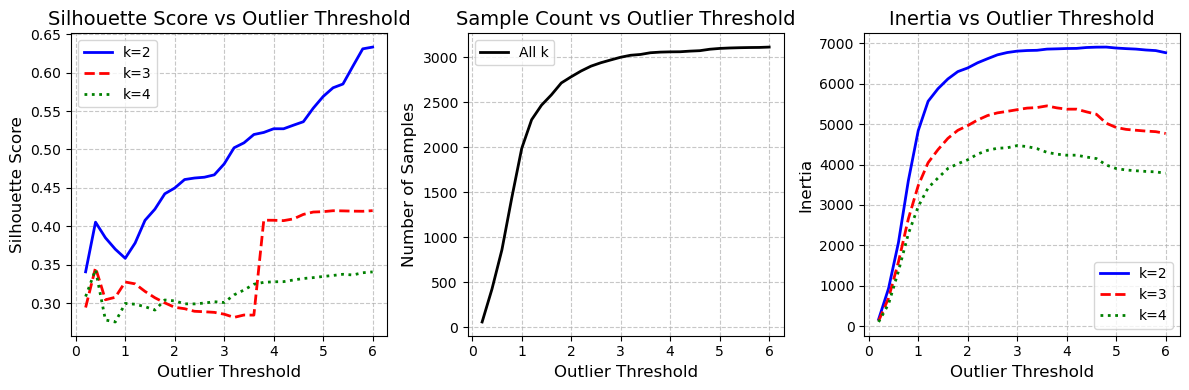


For k=2:
Best outlier threshold: 6.0 with silhouette score: 0.633
Number of samples with best threshold: 3114
Inertia with best threshold: 6770.549471864976

For k=3:
Best outlier threshold: 6.0 with silhouette score: 0.421
Number of samples with best threshold: 3114
Inertia with best threshold: 4769.893422883429

For k=4:
Best outlier threshold: 0.4 with silhouette score: 0.344
Number of samples with best threshold: 425
Inertia with best threshold: 544.0364371285708


In [58]:

# Only proceed with clustering if we have data
if len(df_for_clustering) > 0:
    # Create a copy of the data for scaling
    X = df_for_clustering[feature_cols].values
    depth_array = df_for_clustering['depth'].values

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
else:
    print("Warning: No complete data rows found for the selected features.")
    # Create an empty DataFrame with the necessary columns for downstream code
    df_for_clustering = pd.DataFrame(columns=feature_cols + ['depth', 'cluster_label', 'rock_type'])


# Test different outlier thresholds to find the optimal clustering result

outlier_thresholds = [i * 0.2 for i in range(1, 31)]
silhouette_scores = {k: [] for k in [2, 3, 4]}
inertia_values = {k: [] for k in [2, 3, 4]}
sample_counts = []
cluster_results = {k: [] for k in [2, 3, 4]}

for threshold in outlier_thresholds:
    # Select features and handle missing data
    df_temp = df_merged.dropna(subset=feature_cols).copy()
    
    # Calculate z-scores and filter outliers based on current threshold
    z_scores = stats.zscore(df_temp[feature_cols])
    abs_z_scores = np.abs(z_scores)
    outlier_mask = (abs_z_scores < threshold).all(axis=1)
    df_filtered = df_temp[outlier_mask]
    
    # Store the sample count (only need to do this once per threshold)
    sample_count = len(df_filtered)
    sample_counts.append(sample_count)
    
    # Test each k value
    for k in [2, 3, 4]:
        # Only proceed if we have enough data
        if sample_count > k:
            # Scale the data
            X = df_filtered[feature_cols].values
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            # Apply K-means
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_scaled)
            
            # Calculate silhouette score and inertia
            sil_score = silhouette_score(X_scaled, labels) if len(np.unique(labels)) > 1 else 0
            silhouette_scores[k].append(sil_score)
            inertia_values[k].append(kmeans.inertia_)
            
            # Store the clustering results for later visualization
            cluster_results[k].append({
                'threshold': threshold,
                'X_scaled': X_scaled,
                'labels': labels,
                'silhouette': sil_score,
                'sample_count': sample_count
            })
        else:
            silhouette_scores[k].append(0)
            inertia_values[k].append(float('inf'))

# Plot the evaluation metrics in a 1x3 grid
plt.figure(figsize=(12, 4))

# Line styles and colors for different k values
styles = {
    2: ('b-', 'k=2'),
    3: ('r--', 'k=3'),
    4: ('g:', 'k=4')
}

# Silhouette Score vs Outlier Threshold
plt.subplot(1, 3, 1)
for k in [2, 3, 4]:
    style, label = styles[k]
    plt.plot(outlier_thresholds, silhouette_scores[k], style, linewidth=2, label=label)
plt.xlabel('Outlier Threshold', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Outlier Threshold', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Sample Count vs Outlier Threshold
plt.subplot(1, 3, 2)
plt.plot(outlier_thresholds, sample_counts, 'k-', linewidth=2, label='All k')
plt.xlabel('Outlier Threshold', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Sample Count vs Outlier Threshold', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Inertia vs Outlier Threshold
plt.subplot(1, 3, 3)
for k in [2, 3, 4]:
    style, label = styles[k]
    valid_indices = [i for i, inertia in enumerate(inertia_values[k]) if inertia != float('inf')]
    valid_thresholds = [outlier_thresholds[i] for i in valid_indices]
    valid_inertias = [inertia_values[k][i] for i in valid_indices]
    
    if valid_inertias:
        plt.plot(valid_thresholds, valid_inertias, style, linewidth=2, label=label)

plt.xlabel('Outlier Threshold', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Inertia vs Outlier Threshold', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

# Print information about the best threshold for each k
for k in [2, 3, 4]:
    if silhouette_scores[k]:
        best_idx = np.argmax(silhouette_scores[k])
        best_threshold = outlier_thresholds[best_idx]
        print(f"\nFor k={k}:")
        print(f"Best outlier threshold: {best_threshold} with silhouette score: {silhouette_scores[k][best_idx]:.3f}")
        print(f"Number of samples with best threshold: {sample_counts[best_idx]}")
        print(f"Inertia with best threshold: {inertia_values[k][best_idx] if inertia_values[k][best_idx] != float('inf') else 'N/A'}")
    else:
        print(f"\nFor k={k}: No valid clustering results were obtained.")


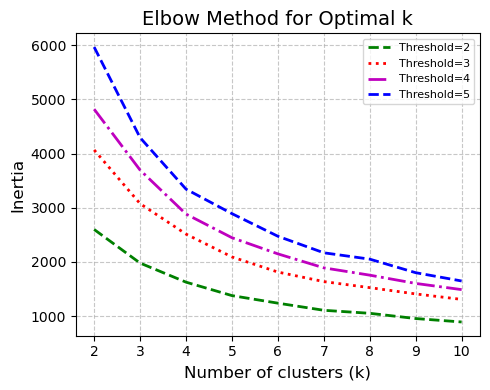

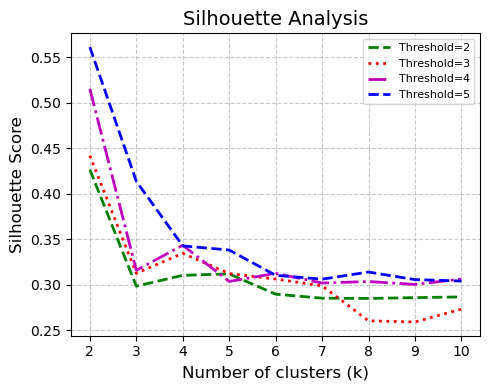


For threshold 2:
Optimal k from elbow method: 3
Best k from silhouette score: 2

For threshold 3:
Optimal k from elbow method: 3
Best k from silhouette score: 2

For threshold 4:
Optimal k from elbow method: 4
Best k from silhouette score: 2

For threshold 5:
Optimal k from elbow method: 4
Best k from silhouette score: 2


In [7]:
# Only proceed with clustering if we have data
if len(df_for_clustering) > 0:
    # Create a copy of the data for scaling
    X = df_for_clustering[feature_cols].values
    depth_array = df_for_clustering['depth'].values

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
else:
    print("Warning: No complete data rows found for the selected features.")
    # Create an empty DataFrame with the necessary columns for downstream code
    df_for_clustering = pd.DataFrame(columns=feature_cols + ['depth', 'cluster_label', 'rock_type'])


inertias = []
sil_scores = []
K_range = range(2, 11)
thresholds = [2, 3, 4, 5]
styles = ['g--', 'r:', 'm-.', 'b--']  # Different line styles for each threshold

# Create dictionaries to store results for each threshold
inertias_by_threshold = {t: [] for t in thresholds}
sil_scores_by_threshold = {t: [] for t in thresholds}

# Calculate metrics for each threshold and k
for threshold in thresholds:
    # Apply outlier filtering for this threshold
    z_scores = stats.zscore(X_scaled)
    abs_z_scores = np.abs(z_scores)
    outlier_mask = (abs_z_scores < threshold).all(axis=1)
    X_filtered = X_scaled[outlier_mask]
    
    if len(X_filtered) > 1:  # Ensure we have enough samples
        for k in K_range:
            kmeans_temp = KMeans(n_clusters=k, random_state=42)
            kmeans_temp.fit(X_filtered)
            
            # Store inertia
            inertias_by_threshold[threshold].append(kmeans_temp.inertia_)
            
            # Store silhouette score if we have enough samples
            if len(X_filtered) > k:
                labels_temp = kmeans_temp.labels_
                score = silhouette_score(X_filtered, labels_temp)
                sil_scores_by_threshold[threshold].append(score)
            else:
                sil_scores_by_threshold[threshold].append(np.nan)

# Plot elbow curves
plt.figure(figsize=(5,4))
for threshold, style in zip(thresholds, styles):
    if len(inertias_by_threshold[threshold]) > 0:
        plt.plot(K_range, inertias_by_threshold[threshold], style, 
                linewidth=2, label=f'Threshold={threshold}')

plt.xlabel("Number of clusters (k)", fontsize=12)
plt.ylabel("Inertia", fontsize=12)
plt.title("Elbow Method for Optimal k", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(5,4))
for threshold, style in zip(thresholds, styles):
    if len(sil_scores_by_threshold[threshold]) > 0:
        plt.plot(K_range, sil_scores_by_threshold[threshold], style,
                linewidth=2, label=f'Threshold={threshold}')

plt.xlabel("Number of clusters (k)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.title("Silhouette Analysis", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Find optimal k for each threshold
for threshold in thresholds:
    if len(inertias_by_threshold[threshold]) > 0:
        # Calculate the percentage change in inertia
        inertias = inertias_by_threshold[threshold]
        inertia_changes = np.diff(inertias) / np.array(inertias[:-1])
        
        # Find where the rate of change slows down significantly
        elbow_candidates = np.where(np.abs(np.diff(inertia_changes)) > np.std(inertia_changes))[0]
        if len(elbow_candidates) > 0:
            optimal_k = K_range[elbow_candidates[0] + 1]
        else:
            # Fallback method
            second_derivative = np.diff(np.diff(inertias))
            optimal_k = K_range[np.argmax(np.abs(second_derivative)) + 2]
            
        # Find best silhouette score
        sil_scores = sil_scores_by_threshold[threshold]
        best_sil_k = K_range[np.nanargmax(sil_scores)]
        
        print(f"\nFor threshold {threshold}:")
        print(f"Optimal k from elbow method: {optimal_k}")
        print(f"Best k from silhouette score: {best_sil_k}")

# 5) K-Means Clustering
Select numeric columns of interest, handle missing data, scale them, and run K-Means to find clusters.

Using optimal k=4 and best outlier threshold=6.0
Number of complete rows for clustering: 3125
Number of rows after outlier removal: 3114
Cluster means:
                        CT       Lumin   Density     hiresMS
cluster_label                                               
0               555.379270  127.714787  1.257654   49.409064
1              1219.091966  101.039176  1.699610  306.219707
2               840.551422  128.845778  1.408385  121.622109
3               624.261771  145.785463  1.305275   53.187344
Cluster distribution:
1 - Turbidite Sand: 146
3 - Pelagic Mud: 696
0 - Turbidite Mud: 1608
2 - Turbidite Laminae: 664


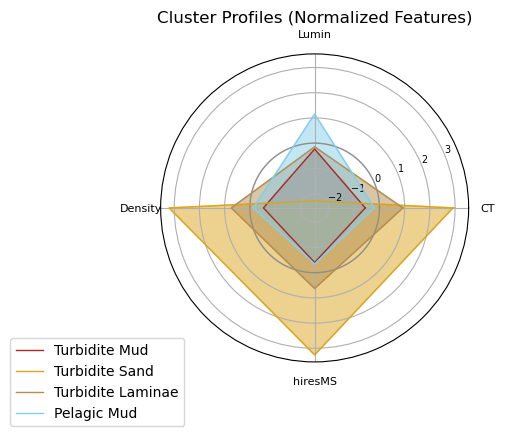

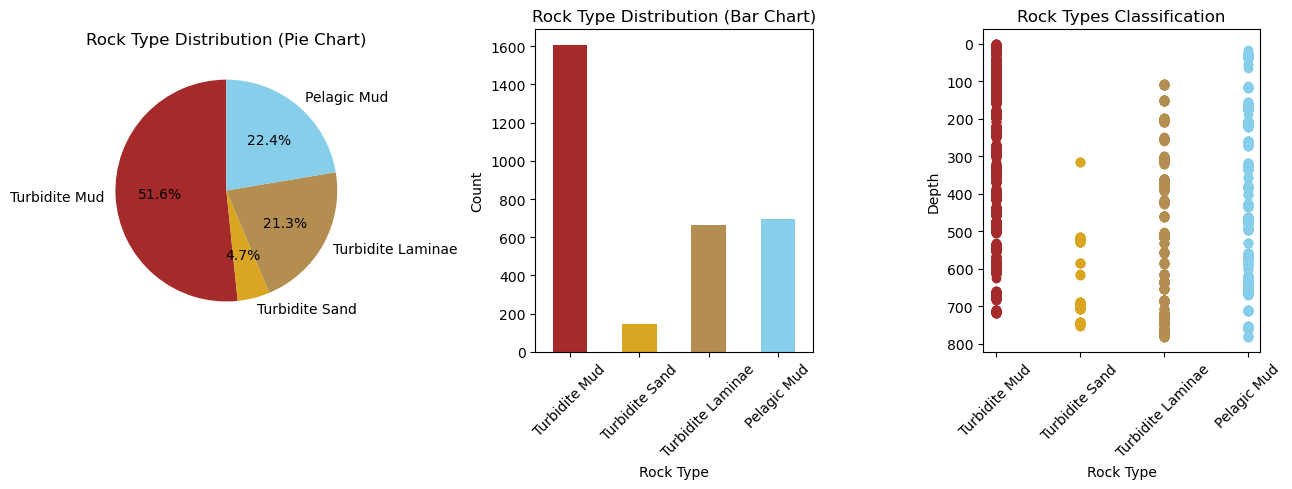

In [56]:
best_threshold = 6.0
k = 4

# Use the optimal k and best outlier threshold found from previous analysis
print(f"Using optimal k={k} and best outlier threshold={best_threshold}")

# Check if there are any rows with complete data for the selected features
df_for_clustering = df_merged.dropna(subset=feature_cols).copy()
print(f"Number of complete rows for clustering: {len(df_for_clustering)}")

# Apply outlier filtering using the newly defined best threshold
z_scores = stats.zscore(df_for_clustering[feature_cols])
abs_z_scores = np.abs(z_scores)
outlier_mask = (abs_z_scores < best_threshold).all(axis=1)
df_for_clustering = df_for_clustering[outlier_mask]

print(f"Number of rows after outlier removal: {len(df_for_clustering)}")

# Only proceed with clustering if we have data
if len(df_for_clustering) > 0:
    # Create a copy of the data for scaling
    X = df_for_clustering[feature_cols].values
    depth_array = df_for_clustering['depth'].values

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Use the optimal k from previous analysis
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)

    labels = kmeans.labels_
    df_for_clustering['cluster_label'] = labels
    
    # Calculate cluster means to determine cluster characteristics
    cluster_means = df_for_clustering.groupby('cluster_label')[feature_cols].mean()
    print("Cluster means:")
    print(cluster_means)
    
    # Determine cluster names based on characteristics
    # Initialize dictionaries for cluster names and colors
    cluster_names = {}
    cluster_colors = {}
    
    # Find the cluster with high hiresMS, density, MS, CT and low RGB/Lumin (Turbidite Sand)
    # sand_indicators = ['hiresMS', 'Density', 'MS', 'CT']
    sand_indicators = ['hiresMS', 'Density', 'CT']
    sand_scores = cluster_means[sand_indicators].mean(axis=1)
    
    # Find the cluster with high RGB and Lumin (Pelagic Mud)
    # pelagic_indicators = ['R', 'G', 'B', 'Lumin']
    pelagic_indicators = ['Lumin']
    pelagic_scores = cluster_means[pelagic_indicators].mean(axis=1)
    
    # Assign cluster names based on characteristics
    turbidite_sand_cluster = sand_scores.idxmax()
    pelagic_mud_cluster = pelagic_scores.idxmax()
    
    # The remaining cluster is Turbidite Mud
    all_clusters = set(range(k))
    assigned_clusters = {turbidite_sand_cluster, pelagic_mud_cluster}
    remaining_clusters = all_clusters - assigned_clusters
    
    # If we have a conflict (same cluster identified for two types), resolve it
    if len(remaining_clusters) < 1:
        # Re-evaluate using more specific criteria
        # For turbidite sand: high density and CT are most important
        sand_specific = cluster_means[['Density', 'CT']].mean(axis=1)
        turbidite_sand_cluster = sand_specific.idxmax()
        
        # For pelagic mud: high RGB values are most important
        # pelagic_specific = cluster_means[['R', 'G', 'B']].mean(axis=1)
        pelagic_specific = cluster_means[['Lumin']].mean(axis=1)
        pelagic_mud_cluster = pelagic_specific.idxmax()
        
        # Recalculate remaining clusters
        assigned_clusters = {turbidite_sand_cluster, pelagic_mud_cluster}
        remaining_clusters = all_clusters - assigned_clusters
    
    # Assign names and colors based on number of clusters
    if k == 2:
        # For k=2, assign Turbidite Sand to cluster with low RGB/Lum and high MS/Density
        # rgb_lum_scores = cluster_means[['R', 'G', 'B', 'Lumin']].mean(axis=1)
        rgb_lum_scores = cluster_means[['Lumin']].mean(axis=1)
        # ms_density_scores = cluster_means[['MS', 'hiresMS', 'Density']].mean(axis=1)
        ms_density_scores = cluster_means[['Density']].mean(axis=1)
        
        # Normalize scores
        rgb_lum_norm = (rgb_lum_scores - rgb_lum_scores.min()) / (rgb_lum_scores.max() - rgb_lum_scores.min())
        ms_density_norm = (ms_density_scores - ms_density_scores.min()) / (ms_density_scores.max() - ms_density_scores.min())
        
        # Calculate combined score (low RGB/Lum and high MS/Density)
        combined_score = ms_density_norm - rgb_lum_norm
        turbidite_sand_cluster = combined_score.idxmax()
        
        # Assign names and colors
        cluster_names[turbidite_sand_cluster] = 'Turbidite Sand'
        cluster_colors[turbidite_sand_cluster] = 'goldenrod'
        
        # Other cluster is Mud
        mud_cluster = 1 if turbidite_sand_cluster == 0 else 0
        cluster_names[mud_cluster] = 'Mud'
        cluster_colors[mud_cluster] = 'brown'
        
    else:
        # For k>=3, first three clusters follow original naming
        cluster_names[turbidite_sand_cluster] = 'Turbidite Sand'
        cluster_colors[turbidite_sand_cluster] = 'goldenrod'
        
        cluster_names[pelagic_mud_cluster] = 'Pelagic Mud'
        cluster_colors[pelagic_mud_cluster] = 'skyblue'
        
        # Assign the remaining cluster as Turbidite Mud
        if remaining_clusters:
            turbidite_mud_cluster = list(remaining_clusters)[0]
            cluster_names[turbidite_mud_cluster] = 'Turbidite Mud'
            cluster_colors[turbidite_mud_cluster] = 'brown'
        
        # For k=4, use a color between brown and skyblue
        if k == 4:
            for i in list(all_clusters):
                if i not in cluster_names:
                    cluster_names[i] = f'Turbidite Laminae'
                    # Mix of brown and skyblue
                    cluster_colors[i] = '#B38E50'  # A color between goldenrod and brown
        
        # For k>4, additional clusters get numbered names and random colors
        elif k > 4:
            for i in list(all_clusters):
                if i not in cluster_names:
                    cluster_names[i] = f'Cluster {i}'
                    r = random.random()
                    g = random.random()
                    b = random.random()
                    cluster_colors[i] = (r, g, b)
    
    # Add cluster names to the dataframe
    df_for_clustering['rock_type'] = df_for_clustering['cluster_label'].map(cluster_names)

    print("Cluster distribution:")
    for cluster_id, name in cluster_names.items():
        count = (df_for_clustering['cluster_label'] == cluster_id).sum()
        print(f"{cluster_id} - {name}: {count}")
    
    # Visualize cluster characteristics with a radar chart
    plt.figure(figsize=(5, 4))
    cluster_centers = kmeans.cluster_centers_
    
    # Get feature names for the radar chart
    feature_names = feature_cols
    
    # Number of variables
    N = len(feature_names)
    
    # Create angles for each feature
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create the plot
    ax = plt.subplot(111, polar=True)
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], feature_names, size=8)
    
    # Set ytick labels to x-small font size
    plt.yticks(size='x-small')
    
    # Add a darker line for 0.0
    ax.plot(np.linspace(0, 2*np.pi, 100), [0]*100, color='gray', linewidth=1.0, linestyle='-', alpha=0.7)
    
    # Draw the cluster profiles
    for i in range(k):
        values = cluster_centers[i].tolist()
        values += values[:1]  # Close the loop
        if i in cluster_names and i in cluster_colors:
            ax.plot(angles, values, linewidth=1.0, linestyle='solid', label=cluster_names[i], color=cluster_colors[i])
            ax.fill(angles, values, alpha=0.5, color=cluster_colors[i])
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Cluster Profiles (Normalized Features)")
    plt.show()
    
    # Visualize cluster distribution
    plt.figure(figsize=(13, 5))
    
    # Plot 1: Pie chart of cluster distribution
    plt.subplot(1, 3, 1)
    cluster_counts = df_for_clustering['cluster_label'].value_counts().sort_index()
    # Fix: Make sure all cluster indices are in the cluster_colors dictionary
    colors = [cluster_colors.get(i, (0.5, 0.5, 0.5)) for i in cluster_counts.index]
    plt.pie(cluster_counts, labels=[cluster_names.get(i, f'Cluster {i}') for i in cluster_counts.index], 
            autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title('Rock Type Distribution (Pie Chart)')
    
    # Plot 2: Bar chart of cluster distribution
    plt.subplot(1, 3, 2)
    cluster_counts.plot(kind='bar', color=colors)
    plt.title('Rock Type Distribution (Bar Chart)')
    plt.xlabel('Rock Type')
    plt.ylabel('Count')
    plt.xticks(range(len(cluster_counts)), [cluster_names.get(i, f'Cluster {i}') for i in cluster_counts.index], rotation=45)
    
    # Plot 3: Depth vs Cluster visualization
    plt.subplot(1, 3, 3)
    
    # Create a scatter plot with consistent colors
    for cluster_id in df_for_clustering['cluster_label'].unique():
        cluster_data = df_for_clustering[df_for_clustering['cluster_label'] == cluster_id]
        plt.scatter([cluster_id] * len(cluster_data), cluster_data['depth'],
                   color=cluster_colors.get(cluster_id, (0.5, 0.5, 0.5)), 
                   label=cluster_names.get(cluster_id, f'Cluster {cluster_id}'))
    
    plt.gca().invert_yaxis()
    plt.title(f"Rock Types Classification")
    plt.xlabel("Rock Type")
    plt.ylabel("Depth")
    
    # Add a custom color bar with meaningful labels
    plt.xticks(sorted(df_for_clustering['cluster_label'].unique()), 
              [cluster_names.get(i, f'Cluster {i}') for i in sorted(df_for_clustering['cluster_label'].unique())], 
              rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("Warning: No complete data rows found for the selected features.")
    # Create an empty DataFrame with the necessary columns for downstream code
    df_for_clustering = pd.DataFrame(columns=feature_cols + ['depth', 'cluster_label', 'rock_type'])

# Cluster Visualization
Plot cluster labels versus depth with a simple scatter. Depth on the y-axis, cluster label on the x-axis, color-coded by label.

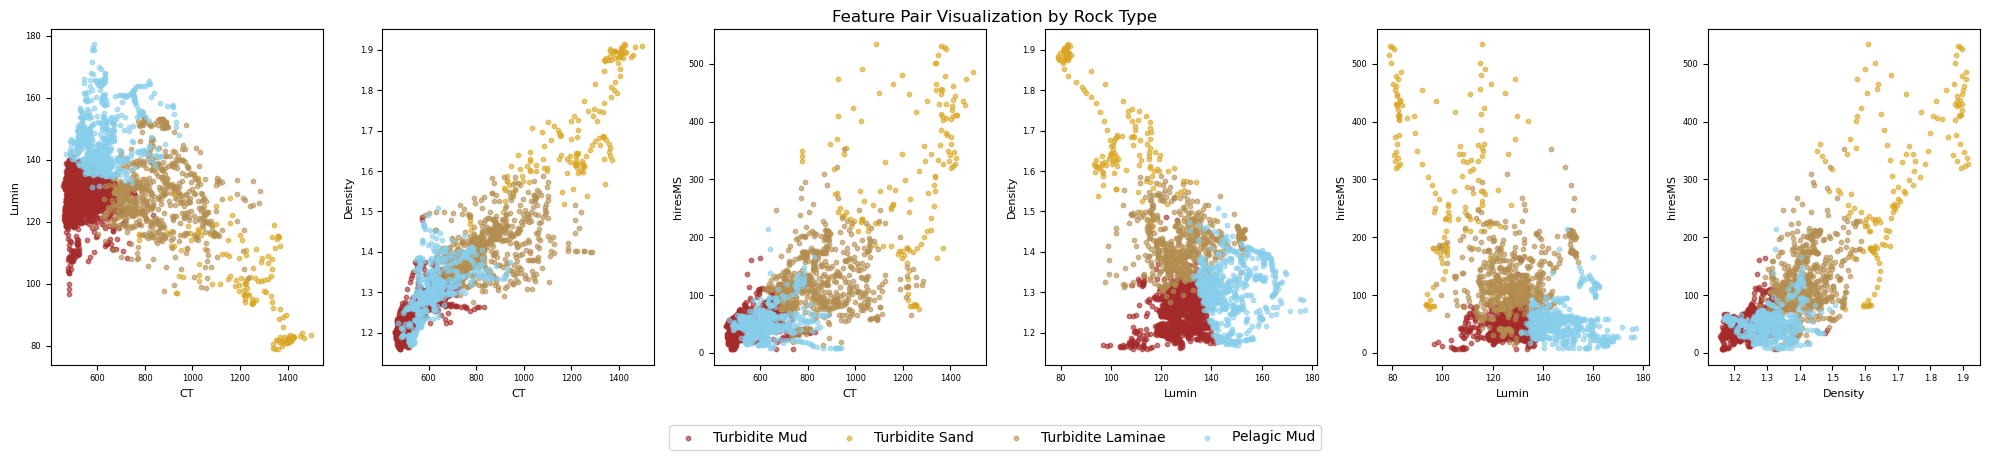

In [59]:
# Create individual feature plots to visualize cluster separation
if len(df_for_clustering) > 0:
    # Use all features for visualization
    vis_features = feature_cols
    
    # Calculate number of feature pairs
    n_features = len(vis_features)
    n_pairs = n_features * (n_features - 1) // 2  # Number of unique pairs
    
    # Calculate number of rows and columns for subplots
    n_cols = 6 # You can adjust this for layout
    n_rows = (n_pairs + n_cols - 1) // n_cols
    
    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4))
    
    # Flatten axes array for easier indexing
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
    
    # Plot each feature pair
    plot_idx = 0
    for i in range(n_features):
        for j in range(i+1, n_features):
            if plot_idx < len(axes):
                ax = axes[plot_idx]
                
                # Get feature names for this pair
                feat_x = vis_features[i]
                feat_y = vis_features[j]
                
                # Scatter plot of feature pair
                for cluster_id in range(k):
                    cluster_points = df_for_clustering[df_for_clustering['cluster_label'] == cluster_id]
                    ax.scatter(cluster_points[feat_x], cluster_points[feat_y], 
                              s=10, alpha=0.6, color=cluster_colors[cluster_id], 
                              label=cluster_names[cluster_id])
                
                # Set labels
                ax.set_xlabel(feat_x, fontsize=8)
                ax.set_ylabel(feat_y, fontsize=8)
                ax.tick_params(axis='both', which='major', labelsize=6)
                
                plot_idx += 1
    
    # Hide any unused subplots
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    # Add a single legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    # Place legend outside the figure at the bottom
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=k)
    
    # Adjust figure margins to make room for the legend
    plt.subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.suptitle("Feature Pair Visualization by Rock Type", y=1.01)
    plt.show()

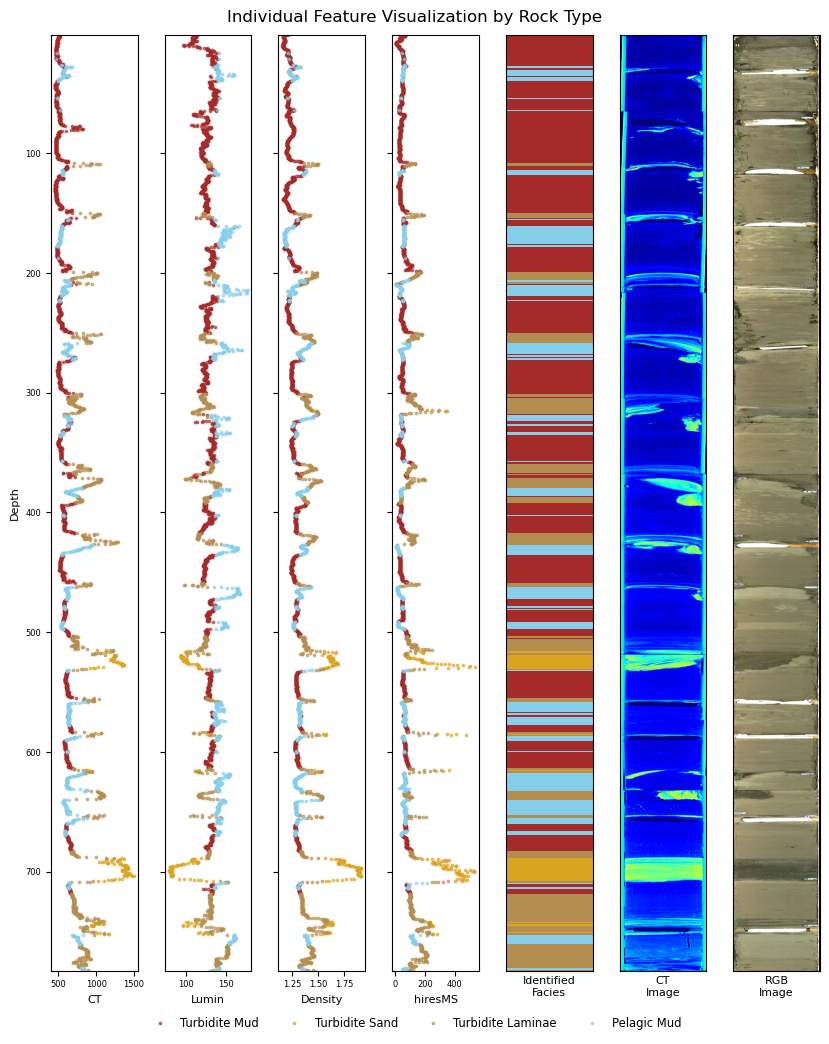

In [60]:
# 3. Create individual feature plots to visualize cluster separation, with cluster column and images at the rightmost,
# with cluster column at the far right, and CT/RGB images immediately to its left if available

# ---- BEGIN image path and loading (copy @top, so image variables are available) ----
# Core parameters
core_name = "M9907-23PC"  # Core name
total_length_cm = 783     # Core length in cm

mother_dir = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/'

# Load CT and RGB images (try...except in case file not found)
ct_img_path = mother_dir + f'_compiled_logs/{core_name}/{core_name}_CT.tiff'
rgb_img_path = mother_dir + f'_compiled_logs/{core_name}/{core_name}_RGB.tiff'
ct_img = None
rgb_img = None
try:
    ct_img = plt.imread(ct_img_path)
except Exception:
    pass
try:
    rgb_img = plt.imread(rgb_img_path)
except Exception:
    pass
# ---- END image path and loading ----

if len(df_for_clustering) > 0:
    # Use all features for visualization
    vis_features = feature_cols

    # Try to include ct_img and rgb_img if loaded; skip otherwise
    ct_img_available = ct_img is not None
    rgb_img_available = rgb_img is not None

    # Image/cluster columns will be at the right
    image_cols = []
    if ct_img_available:
        image_cols.append('ct')
    if rgb_img_available:
        image_cols.append('rgb')

    # Work out order: [features ...][cluster_column][ct_img][rgb_img]
    total_cols = len(vis_features) + 1 + len(image_cols)  # +1 for cluster column
    n_rows = 1  # always 1 row as per instruction

    fig, axes = plt.subplots(n_rows, total_cols, figsize=(1.2*total_cols, 10))
    if total_cols == 1:
        axes = np.array([axes])
    axes = np.atleast_2d(axes)

    # Prepare the depth/labels
    df_for_clustering_sorted = df_for_clustering.sort_values(by='depth').reset_index(drop=True)
    depth_vals = df_for_clustering_sorted['depth'].values
    labels_vals = df_for_clustering_sorted['cluster_label'].values

    # ---- Feature scatter plots: left side ----
    handles, labels = None, None
    for feature_col_idx, feat in enumerate(vis_features):
        ax = axes[0, feature_col_idx]
        for cluster_id in range(k):
            cluster_points = df_for_clustering[df_for_clustering['cluster_label'] == cluster_id]
            ax.scatter(cluster_points[feat], cluster_points['depth'],
                       s=3, alpha=0.6, color=cluster_colors[cluster_id],
                       label=cluster_names[cluster_id])
        ax.set_xlabel(feat, fontsize=8)
        # Let matplotlib automatically set x-axis limits with default spacing
        ax.autoscale(enable=True, axis='x', tight=False)
        # Set y-axis limits with no extra space at the edges
        ax.set_ylim([depth_vals.max(), depth_vals.min()])
        # Only the leftmost feature column prints y axis depth number labels
        if feature_col_idx == 0:
            ax.set_ylabel('Depth', fontsize=8)
            ax.tick_params(axis='y', which='both', labelleft=True, left=True)
        else:
            ax.set_ylabel('', fontsize=8)
            ax.tick_params(axis='y', which='both', labelleft=False, left=True)
        ax.tick_params(axis='both', which='major', labelsize=6)
        # Save handles/labels for legend if not set yet
        if handles is None or labels is None:
            handles, labels = ax.get_legend_handles_labels()

    # --- Cluster column right after features, then CT/RGB images at the rightmost columns ---
    next_col = len(vis_features)  # starting index for cluster column

    # Lithology/cluster column: right after features
    lith_ax = axes[0, next_col]
    for i in range(len(depth_vals) - 1):
        top = depth_vals[i]
        bottom = depth_vals[i + 1]
        c_label = labels_vals[i]
        color = cluster_colors[c_label]
        lith_ax.add_patch(
            mpatches.Rectangle((0, top), 1, bottom - top, facecolor=color, edgecolor='none')
        )
    lith_ax.set_ylim([depth_vals.max(), depth_vals.min()])
    lith_ax.set_xlim([0, 1])
    lith_ax.set_xticks([])
    lith_ax.set_yticks([])
    lith_ax.set_ylabel("")
    lith_ax.tick_params(axis='y', which='both', labelleft=False, left=True)
    lith_ax.set_xlabel("Identified\nFacies", fontsize=8)
    next_col += 1

    # CT image (if available)
    if ct_img_available:
        img_ax = axes[0, next_col]
        img_ax.imshow(ct_img, aspect='auto', extent=[0, 1, depth_vals.max(), depth_vals.min()])
        img_ax.set_xticks([])
        img_ax.set_yticks([])
        img_ax.set_ylabel("")
        img_ax.tick_params(axis='y', which='both', labelleft=False, left=True)
        img_ax.set_xlabel('CT\nImage', fontsize=8)
        next_col += 1

    # RGB image (if available)
    if rgb_img_available:
        img_ax = axes[0, next_col]
        img_ax.imshow(rgb_img, aspect='auto', extent=[0, 1, depth_vals.max(), depth_vals.min()])
        img_ax.set_xticks([])
        img_ax.set_yticks([])
        img_ax.set_ylabel("")
        img_ax.tick_params(axis='y', which='both', labelleft=False, left=True)
        img_ax.set_xlabel('RGB\nImage', fontsize=8)
        next_col += 1

    # Hide any unused axes (shouldn't happen with this setup but just in case)
    for i in range(next_col, axes.shape[1]):
        axes[0, i].set_visible(False)

    # Add a single legend for the entire figure, outside the figure at center (bottom)
    if handles and labels:
        fig.legend(handles, labels, loc='lower center', 
                   ncol=k, fontsize='small', frameon=False, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout()
    plt.suptitle("Individual Feature Visualization by Rock Type", y=1.01)
    plt.show()
